In [1]:
import pandas as pd
import numpy as np
import os
import math
import re
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
import igraph as ig
from collections import Counter
import scipy.stats
import seaborn as sns
from matplotlib.font_manager import FontProperties  # 导入FontProperties
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
import warnings
import networkx as nx
warnings.filterwarnings("ignore")

In [2]:
from math import log10

# data import

In [3]:
class DI_network:

    def open_file(self , path):
        file_lst = os.listdir(path)
        data = []
        for file in file_lst:
            with open(os.path.join(path , file), 'r', encoding='unicode_escape') as f:
                data.extend(f.readlines()[2:])
        return data
 
    def get_data(self , txt):
        p_lst = []                        #p_lst是存储全部文献内容的列表（每篇文献为列表中的一个值）
        t_p_lst = []                      #t_p_lst是为了提取出p_lst的临时列表
        for t in txt:
            t_p_lst.append(t[:-1])
            if t =='\n':
                p_lst.append(t_p_lst)
                t_p_lst = []
        return p_lst
    
    def get_reference(self , p):             #此函数可以提取出该文献内容中参考文献的列表
        reference_lst = []
        on0 = False
        on1 = True
        for pi in p:
            if pi[:2] == 'CR':
                on0 = True
            if pi[:2] == 'NR':
                on1 = False
            if on0 == True and on1 == True:
                reference_lst.append(pi[3:])
        return reference_lst
    
    def get_ti(self , p):             #此函数可以提取出该文献内容中标题
        for pi in p:
            if pi[:2] == 'TI':
                p_ti = pi[2:].strip()
                return p_ti
    
    def get_tc(self , p):             #此函数可以提取出该文献被引量
        for pi in p:
            if pi[:2] == 'TC':
                p_ti = int(pi[2:])
                return p_ti
        return np.nan
    
    def get_doi(self , p):             
        for pi in p:
            if pi[:2] == 'DI':
                p_ti = pi[2:].strip()
                return p_ti
        return np.nan
    
    def get_au(self , p):             
        for pi in p:
            if pi[:2] == 'AU':
                p_ti = pi[2:].strip()
                return p_ti
        return np.nan
    
    def get_year(self , p):             
        for pi in p:
            if pi[:2] == 'PY':
                p_ti = pi[2:].strip()
                return p_ti
        return np.nan

In [4]:
di = DI_network()
path = r'E:\目前研究项目\网络构建\JOI'

In [5]:
citing_data = di.open_file(path)
p_data = di.get_data(citing_data)
reference = di.get_reference(p_data[0])
ti = di.get_ti(p_data[0])
tc = di.get_tc(p_data[0])
doi = di.get_doi(p_data[0])
au = di.get_au(p_data[0])
year = di.get_year(p_data[0])
meta_inf = au + ' ' + year

# construct a network

In [6]:
meta_inf_lst = []           #FP的META
doi_lst = []                #FP的DOI
ref_doi_lst = []            #被引文献的DOI列表
ti_lst = []
tc_lst = []

for p in p_data:
    reference = di.get_reference(p)
    doi = di.get_doi(p)
    au = di.get_au(p)
    year = di.get_year(p)
    ti = di.get_ti(p)
    tc = di.get_tc(p)
    meta_inf = au + ' ' + year
    
    meta_inf_lst.append(meta_inf)
    doi_lst.append(doi)
    ti_lst.append(ti)
    tc_lst.append(tc)
    
    ref_doi_lst_small = []
    for line in reference:
        if re.search( 'DOI 10.+', line)!= None:
            ref_doi_lst_small.append(re.search( 'DOI 10.+', line).group()[4:])
    
    ref_doi_lst.append(ref_doi_lst_small)

In [7]:
M = len(p_data)
adj_matrix = np.zeros((M,M))
for i in range(M):
    C_doi = doi_lst[i]
    for j in range(M):
        if C_doi in ref_doi_lst[j]:
            adj_matrix[i, j] = 1

In [8]:
df = pd.DataFrame(adj_matrix , columns = meta_inf_lst , index = meta_inf_lst)

In [27]:
g = ig.Graph.Adjacency(adj_matrix)

In [28]:
n = g.to_networkx()

# METAandDIO

In [11]:
ff = pd.read_excel('netdata/JOIdata.xlsx')

In [12]:
ff

,meta_inf,ti,DIO,2stepDIO,degree,coreness,h-index,pagerank,in-degree,out-degree
0,"Vanclay, JK 2011",An evaluation of the Australian Research Counc...,0.045455,0.182390,15,6,8,0.000518,4,11
1,"Ortega, JL 2010",Differences between web sessions according to ...,NaN,NaN,0,0,0,0.000364,0,0
2,"Wang, GB 2010",The role of patenting activity for scientific ...,0.000000,0.000000,1,1,1,0.000426,1,0
3,"Rousseau, R 2010",A discussion of Prathap's h(2)-index for insti...,0.027778,0.320988,5,5,5,0.000472,3,2
4,"Rodriguez, MA 2010",Exposing multi-relational networks to single-r...,0.000000,0.000000,1,1,1,0.000373,1,0
...,...,...,...,...,...,...,...,...,...,...
1252,"Schubert, A 2012",Jazz discometrics - A network approach,1.000000,1.000000,2,2,2,0.000364,0,2
1253,"Wang, MY 2012",Development a case-based classifier for predic...,0.029851,0.073034,5,5,5,0.000456,2,3
1254,"Schreiber, M 2012",Exploratory factor analysis for the Hirsch ind...,0.065789,0.237624,13,6,7,0.000437,4,9
1255,"Yan, E 2012",Topics in dynamic research communities: An exp...,0.454545,0.647059,7,3,4,0.000408,1,6


In [16]:
g = ig.Graph.from_networkx(n)

# MAXconnected_components

In [51]:
ff.sort_values('DIO',ascending=False)

,meta_inf,ti,DIO,2stepDIO,degree,coreness,h-index,pagerank,in-degree,out-degree
441,"Schreiber, M 2008",A modification of the h-index: The h(m)-index ...,1.0,1.0,21,6,10,0.000364,0,21
431,"Sugimoto, CR 2013",Journal acceptance rates: A cross-disciplinary...,1.0,1.0,1,1,1,0.000364,0,1
992,"Costas, R 2007","The h-index: Advantages, limitations and its r...",1.0,1.0,25,6,8,0.000364,0,25
117,"Klavans, R 2014",Mapping altruism,1.0,1.0,1,1,1,0.000364,0,1
747,"Glanzel, W 2010",Hirsch-type characteristics of the tail of dis...,1.0,1.0,2,2,2,0.000364,0,2
...,...,...,...,...,...,...,...,...,...,...
1163,"Waltman, L 2016",Special section on statistical inference in ci...,NaN,NaN,0,0,0,0.000364,0,0
1182,"Rodriguez, MA 2007",Mapping the bid behavior of conference referees,NaN,NaN,0,0,0,0.000364,0,0
1190,"Pandey, PK 2020",Analysis of reference and citation copying in ...,NaN,NaN,0,0,0,0.000364,0,0
1232,"Valderrama-Zurian, JC 2019","Origin, characteristics, predominance and conc...",NaN,NaN,0,0,0,0.000364,0,0


In [87]:
N = nx.Graph(n)

In [1]:
# components_degree = []
# components_degree.append(len(max(nx.connected_components(N), key=len)))
# for i in ff.sort_values('degree',ascending=False).index:
#     N.remove_nodes_from([i])
#     components_degree.append(len(max(nx.connected_components(N), key=len)))

# components_DIO = []
# components_DIO.append(len(max(nx.connected_components(N), key=len)))
# for i in ff.sort_values('DIO',ascending=False).index:
#     N.remove_nodes_from([i])
#     components_DIO.append(len(max(nx.connected_components(N), key=len)))
    
# components_GDIO = []
# components_GDIO.append(len(max(nx.connected_components(N), key=len)))
# for i in ff.sort_values('2stepDIO',ascending=False).index:
#     N.remove_nodes_from([i])
#     components_GDIO.append(len(max(nx.connected_components(N), key=len)))

# components_hindex = []
# components_hindex.append(len(max(nx.connected_components(N), key=len)))
# for i in ff.sort_values('h-index',ascending=False).index:
#     N.remove_nodes_from([i])
#     components_hindex.append(len(max(nx.connected_components(N), key=len)))

components_pagerank = []
components_pagerank.append(len(max(nx.connected_components(N), key=len)))
for i in ff.sort_values('pagerank',ascending=False).index:
    N.remove_nodes_from([i])
    components_pagerank.append(len(max(nx.connected_components(N), key=len)))

In [89]:
sum(components_pagerank)/len(components_pagerank)

446.43754972155926

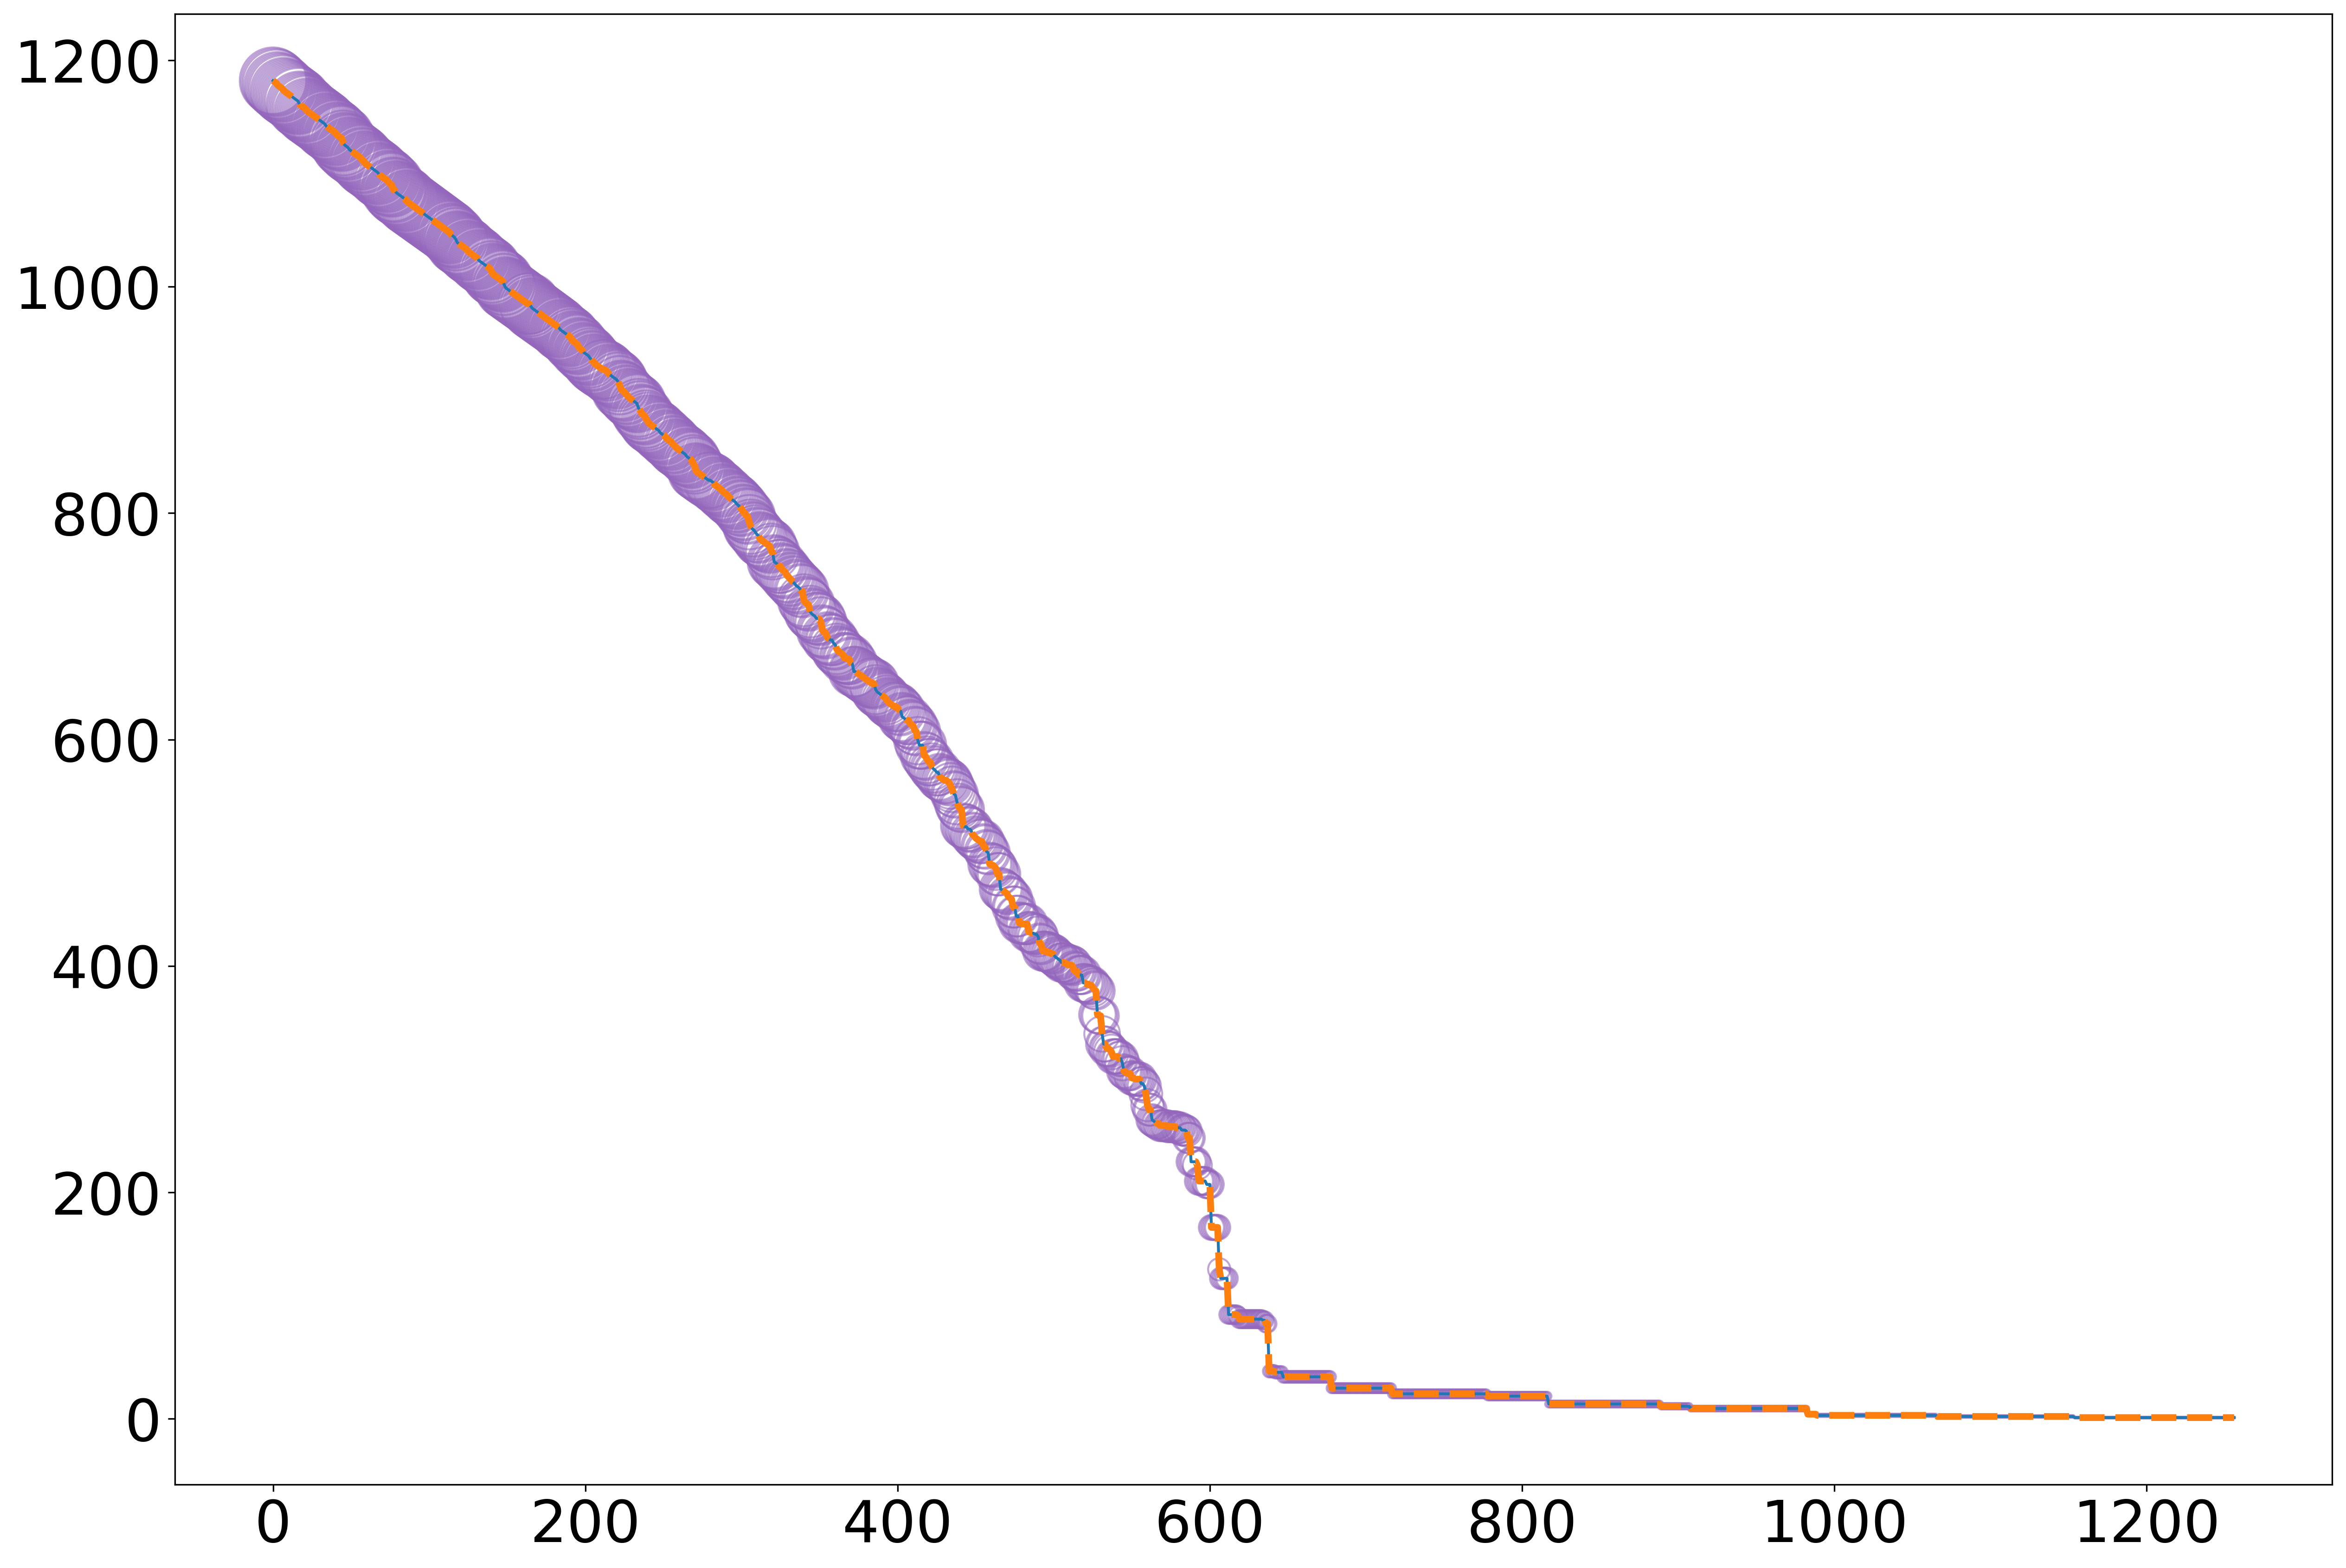

In [91]:
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(20, 14), dpi=300)
# plt.scatter(range(len(n)),components_degree,s=components_degree,facecolors ='none',edgecolors=c[0],alpha=0.6,label='degree')
# plt.plot(range(len(n)),components_degree)
# plt.plot(range(len(n)),components_degree,linestyle = '--', linewidth=3.5,label='degree')
# plt.xticks(fontsize=30)
# plt.yticks(fontsize=30)
# plt.show()

# plt.scatter(range(len(n)),components_DIO,s=components_DIO,facecolors ='none',edgecolors=c[1],alpha=0.6,label='DIO')
# plt.plot(range(len(n)),components_DIO)
# plt.plot(range(len(n)),components_DIO,linestyle = '--', linewidth=3.5,label='DIO')
# plt.xticks(fontsize=30)
# plt.yticks(fontsize=30)
# plt.show()

# plt.scatter(range(len(n)),components_GDIO,s=components_GDIO,facecolors ='none',edgecolors=c[2],alpha=0.6,label='2stepDIO')
# plt.plot(range(len(n)),components_GDIO)
# plt.plot(range(len(n)),components_GDIO,linestyle = '--', linewidth=3.5,label='2stepDIO')
# plt.xticks(fontsize=30)
# plt.yticks(fontsize=30)
# plt.show()

# plt.scatter(range(len(n)),components_coreness,s=components_coreness,facecolors ='none',edgecolors=c[3],alpha=0.6,label='coreness')
# plt.plot(range(len(n)),components_coreness)
# plt.plot(range(len(n)),components_coreness,linestyle = '--', linewidth=3.5,label='coreness')
# plt.xticks(fontsize=30)
# plt.yticks(fontsize=30)
# plt.show()

plt.scatter(range(len(n)),components_hindex,s=components_hindex,facecolors ='none',edgecolors=c[4],alpha=0.6,label='coreness')
plt.plot(range(len(n)),components_hindex)
plt.plot(range(len(n)),components_hindex,linestyle = '--', linewidth=3.5,label='coreness')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

# plt.scatter(range(len(n)),components_pagerank,s=components_pagerank,facecolors ='none',edgecolors=c[5],alpha=0.6,label='pagerank')
# plt.plot(range(len(n)),components_pagerank)
# plt.plot(range(len(n)),components_pagerank,linestyle = '--', linewidth=3.5,label='pagerank')
# plt.xticks(fontsize=30)
# plt.yticks(fontsize=30)
# plt.show()

In [46]:
len(n)

1257